In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, sum, when, expr, row_number, month
from pyspark.sql.window import Window

Q1.1

In [0]:
flight_data_path = "/FileStore/tables/flight_data-1.csv"  # Replace with actual file path
df = spark.read.csv(flight_data_path, header=True, inferSchema=True)

In [0]:
df.printSchema

Out[3]: <bound method DataFrame.printSchema of DataFrame[YEAR: int, MONTH: int, DAY: int, DAY_OF_WEEK: int, AIRLINE: string, FLIGHT_NUMBER: int, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, DEPARTURE_DELAY: int, ARRIVAL_DELAY: int, CANCELLED: int]>

In [0]:
df = df.withColumn("Flight_Number", col("Flight_Number").cast("string"))

In [0]:
from pyspark.sql.functions import concat_ws, to_date
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Concatenate Year, Month, and Day into a single string
df = df.withColumn("Flight_Date", concat_ws("-", col("YEAR"), col("MONTH"), col("DAY")))

# Convert it into a proper Date format
df = df.withColumn("Flight_Date", to_date(col("Flight_Date"), "yyyy-MM-dd"))

# Show results
df.select("Year", "Month", "Day", "Flight_Date").show(5)

+----+-----+---+-----------+
|Year|Month|Day|Flight_Date|
+----+-----+---+-----------+
|2015|    1|  1| 2015-01-01|
|2015|    1|  1| 2015-01-01|
|2015|    1|  1| 2015-01-01|
|2015|    1|  1| 2015-01-01|
|2015|    1|  1| 2015-01-01|
+----+-----+---+-----------+
only showing top 5 rows



In [0]:
df.printSchema

Out[6]: <bound method DataFrame.printSchema of DataFrame[YEAR: int, MONTH: int, DAY: int, DAY_OF_WEEK: int, AIRLINE: string, Flight_Number: string, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, DEPARTURE_DELAY: int, ARRIVAL_DELAY: int, CANCELLED: int, Flight_Date: date]>

In [0]:
df1 = df.drop("YEAR","MONTH","DAY","DepartureDelay","ArrivalDelay","DAY_OF_WEEK")

In [0]:
df1.show(10)

+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|AIRLINE|Flight_Number|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|ARRIVAL_DELAY|CANCELLED|Flight_Date|
+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|     AS|           98|           ANC|                SEA|            -11|          -22|        0| 2015-01-01|
|     AA|         2336|           LAX|                PBI|             -8|           -9|        0| 2015-01-01|
|     US|          840|           SFO|                CLT|             -2|            5|        0| 2015-01-01|
|     AA|          258|           LAX|                MIA|             -5|           -9|        0| 2015-01-01|
|     AS|          135|           SEA|                ANC|             -1|          -21|        0| 2015-01-01|
|     DL|          806|           SFO|                MSP|             -5|            8|        0| 2015-01-01|
|

Q1.2

In [0]:
rdd = df1.rdd  # Convert to RDD
print("Total number of flights:", rdd.count()) 

Total number of flights: 1048575


In [0]:
df1 = rdd.toDF()
df1.show(10)

+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|AIRLINE|Flight_Number|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|ARRIVAL_DELAY|CANCELLED|Flight_Date|
+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|     AS|           98|           ANC|                SEA|            -11|          -22|        0| 2015-01-01|
|     AA|         2336|           LAX|                PBI|             -8|           -9|        0| 2015-01-01|
|     US|          840|           SFO|                CLT|             -2|            5|        0| 2015-01-01|
|     AA|          258|           LAX|                MIA|             -5|           -9|        0| 2015-01-01|
|     AS|          135|           SEA|                ANC|             -1|          -21|        0| 2015-01-01|
|     DL|          806|           SFO|                MSP|             -5|            8|        0| 2015-01-01|
|

Q1.3

In [0]:
df.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- Flight_Number: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- Flight_Date: date (nullable = true)



Q1.4

In [0]:
df1.createOrReplaceTempView("flights")
result_df = spark.sql("SELECT * FROM flights LIMIT 10")
result_df.show(10)

+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|AIRLINE|Flight_Number|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|ARRIVAL_DELAY|CANCELLED|Flight_Date|
+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|     AS|           98|           ANC|                SEA|            -11|          -22|        0| 2015-01-01|
|     AA|         2336|           LAX|                PBI|             -8|           -9|        0| 2015-01-01|
|     US|          840|           SFO|                CLT|             -2|            5|        0| 2015-01-01|
|     AA|          258|           LAX|                MIA|             -5|           -9|        0| 2015-01-01|
|     AS|          135|           SEA|                ANC|             -1|          -21|        0| 2015-01-01|
|     DL|          806|           SFO|                MSP|             -5|            8|        0| 2015-01-01|
|

Q2.1

In [0]:
from pyspark.sql.functions import when, col

df1 = df1.withColumn("DEPARTURE_DELAY", when(col("DEPARTURE_DELAY").isNull(), 0).otherwise(col("DEPARTURE_DELAY")))
df1 = df1.withColumn("ARRIVAL_DELAY", when(col("ARRIVAL_DELAY").isNull(), 0).otherwise(col("ARRIVAL_DELAY")))

Q2.3

In [0]:
df1 = df1.withColumn("TotalDelay", col("DEPARTURE_DELAY") + col("ARRIVAL_DELAY"))
df.show(5)

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|Flight_Number|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|ARRIVAL_DELAY|CANCELLED|Flight_Date|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+
|2015|    1|  1|          4|     AS|           98|           ANC|                SEA|            -11|          -22|        0| 2015-01-01|
|2015|    1|  1|          4|     AA|         2336|           LAX|                PBI|             -8|           -9|        0| 2015-01-01|
|2015|    1|  1|          4|     US|          840|           SFO|                CLT|             -2|            5|        0| 2015-01-01|
|2015|    1|  1|          4|     AA|          258|           LAX|                MIA|             -5|           -9|        0| 2015-01-01|
|2015|    1|  1|          4|     A

In [0]:
df1= df1.drop("ArrivalDelay","DepartureDelay")

In [0]:
df1.show(10)

+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+----------+
|AIRLINE|Flight_Number|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|ARRIVAL_DELAY|CANCELLED|Flight_Date|TotalDelay|
+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+----------+
|     AS|           98|           ANC|                SEA|            -11|          -22|        0| 2015-01-01|       -33|
|     AA|         2336|           LAX|                PBI|             -8|           -9|        0| 2015-01-01|       -17|
|     US|          840|           SFO|                CLT|             -2|            5|        0| 2015-01-01|         3|
|     AA|          258|           LAX|                MIA|             -5|           -9|        0| 2015-01-01|       -14|
|     AS|          135|           SEA|                ANC|             -1|          -21|        0| 2015-01-01|       -22|
|     DL|          806| 

Q2.4

In [0]:
flight_not_cancelled = df1.filter(col("CANCELLED") == 0)
flight_not_cancelled.show(10)

+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+----------+
|AIRLINE|Flight_Number|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|ARRIVAL_DELAY|CANCELLED|Flight_Date|TotalDelay|
+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+----------+
|     AS|           98|           ANC|                SEA|            -11|          -22|        0| 2015-01-01|       -33|
|     AA|         2336|           LAX|                PBI|             -8|           -9|        0| 2015-01-01|       -17|
|     US|          840|           SFO|                CLT|             -2|            5|        0| 2015-01-01|         3|
|     AA|          258|           LAX|                MIA|             -5|           -9|        0| 2015-01-01|       -14|
|     AS|          135|           SEA|                ANC|             -1|          -21|        0| 2015-01-01|       -22|
|     DL|          806| 

Q3.1

In [0]:
from pyspark.sql.functions import avg

df1.groupBy("AIRLINE").agg(avg("DEPARTURE_DELAY").alias("AvgDepartureDelay")).orderBy(col("AvgDepartureDelay").desc()).show(20)


+-------+------------------+
|AIRLINE| AvgDepartureDelay|
+-------+------------------+
|     F9|22.833117458586134|
|     MQ| 16.06989452475081|
|     NK|15.709055680195798|
|     B6| 15.04879872085055|
|     UA| 14.71109284752186|
|     OO|10.967030504486504|
|     AA|10.795169607069267|
|     EV| 10.70040285596101|
|     VX|10.030375853119292|
|     WN| 9.767489823364292|
|     DL| 9.481835564053537|
|     US|  7.25271158475562|
|     AS| 2.884649152427906|
|     HA| 1.546310054482417|
+-------+------------------+



Q3.2

In [0]:
from pyspark.sql.functions import count
df1.groupBy("ORIGIN_AIRPORT", "DESTINATION_AIRPORT").agg(count("*").alias("FlightCount")).orderBy(col("FlightCount").desc()).show(5)

+--------------+-------------------+-----------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|FlightCount|
+--------------+-------------------+-----------+
|           JFK|                LAX|       2524|
|           LAX|                JFK|       2522|
|           SFO|                LAX|       2494|
|           LAX|                SFO|       2449|
|           LAS|                LAX|       2117|
+--------------+-------------------+-----------+
only showing top 5 rows



Q3.3

In [0]:
total_flights = df1.count()
delayed_flights = df1.filter(col("DEPARTURE_DELAY") > 15).count()
percentage = (delayed_flights / total_flights) * 100

print(f"Percentage of flights with delay > 15 minutes: {percentage:.2f}%")


Percentage of flights with delay > 15 minutes: 20.16%


Q3.4

In [0]:
df1.groupBy("DESTINATION_AIRPORT").agg(avg("ARRIVAL_DELAY").alias("AvgArrivalDelay")).orderBy(col("AvgArrivalDelay").desc()).show()

+-------------------+------------------+
|DESTINATION_AIRPORT|   AvgArrivalDelay|
+-------------------+------------------+
|                TTN|40.177949709864606|
|                MQT| 35.91379310344828|
|                SUX|27.519685039370078|
|                OTH|26.615384615384617|
|                ALO|26.385826771653544|
|                COU|25.316176470588236|
|                CMI|25.039823008849556|
|                DBQ|24.106951871657753|
|                CWA|23.493006993006993|
|                MHK|22.131498470948014|
|                CHO|21.714922048997774|
|                STC|21.621951219512194|
|                LSE| 21.26241134751773|
|                TOL|20.866666666666667|
|                ILG| 20.11111111111111|
|                RST|19.523809523809526|
|                ELM|19.365728900255753|
|                CID| 19.24307900067522|
|                SGF| 18.79380664652568|
|                BGM|18.736842105263158|
+-------------------+------------------+
only showing top

Q4.1

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col

windowSpec = Window.partitionBy("AIRLINE").orderBy("Flight_Date").rowsBetween(-3, 0)

df1 = df1.withColumn("RunningAvgDelay", avg("TotalDelay").over(windowSpec))
df1.show(5)

+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+----------+---------------+
|AIRLINE|Flight_Number|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|ARRIVAL_DELAY|CANCELLED|Flight_Date|TotalDelay|RunningAvgDelay|
+-------+-------------+--------------+-------------------+---------------+-------------+---------+-----------+----------+---------------+
|     NK|          612|           LAS|                MSP|             -6|          -17|        0| 2015-01-01|       -23|          -23.0|
|     NK|          520|           LAS|                MCI|             25|            6|        0| 2015-01-01|        31|            4.0|
|     NK|          214|           LAS|                DFW|             -1|           -1|        0| 2015-01-01|        -2|            2.0|
|     NK|          597|           MSP|                FLL|             12|           25|        0| 2015-01-01|        37|          10.75|
|     NK|          168|           

Q4.2

In [0]:
from pyspark.sql.functions import month

df1= df1.withColumn("Month", month(col("Flight_Date")))
df.groupBy("Month", "AIRLINE").count().orderBy(col("count").desc()).show()


+-----+-------+------+
|Month|AIRLINE| count|
+-----+-------+------+
|    1|     WN|100042|
|    2|     WN| 90172|
|    1|     DL| 64421|
|    2|     DL| 60884|
|    1|     EV| 49925|
|    1|     OO| 48114|
|    2|     EV| 45138|
|    1|     AA| 44059|
|    2|     OO| 43989|
|    2|     AA| 39835|
|    1|     UA| 38395|
|    2|     UA| 36235|
|    1|     US| 33489|
|    3|     WN| 31372|
|    2|     US| 30153|
|    1|     MQ| 29900|
|    2|     MQ| 26940|
|    3|     DL| 22181|
|    1|     B6| 21623|
|    2|     B6| 19751|
+-----+-------+------+
only showing top 20 rows



Q5

In [0]:
df1.groupBy("AIRLINE").agg(avg("DEPARTURE_DELAY").alias("AvgDepartureDelay")).write.csv("/FileStore/tables/avg_departure_delay.csv", header=True)


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-531433555136649>:1
----> 1 df1.groupBy("AIRLINE").agg(avg("DEPARTURE_DELAY").alias("AvgDepartureDelay")).write.csv("/FileStore/tables/avg_departure_delay.csv", header=True)

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/readwriter.py:1798, in DataFrameWriter.csv(self, path, mode, compression, sep, quote, escape, header, nullValue, escapeQuotes, quoteAll, dateFormat, timestampFormat, ignoreLeadingWhiteSpace, ignoreTrailingWhiteSpace, charToEscapeQuoteEscaping, e

Q6.1

In [0]:
%sql
SELECT Airline, COUNT(*) AS CancelledCount
FROM flights
WHERE Cancelled = 1
GROUP BY Airline
ORDER BY CancelledCount DESC
LIMIT 10;


Airline,CancelledCount
MQ,7727
WN,6606
EV,6274
AA,4685
US,3143
OO,2983
DL,2861
B6,2645
UA,2403
NK,461


Q6.2

In [0]:
%sql
SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT, MIN(AvgArrivalDelay) 
FROM (
    SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT, AVG(ARRIVAL_DELAY) AS AvgArrivalDelay 
    FROM flights 
    GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT
) 
GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT;


ORIGIN_AIRPORT,DESTINATION_AIRPORT,min(AvgArrivalDelay)
BQN,MCO,8.4
PHL,MCO,10.469430051813472
MCI,IAH,5.449685534591195
SPI,ORD,12.214634146341464
SNA,PHX,4.354673495518566
LBB,DEN,13.19548872180451
ORD,PDX,7.893280632411067
EWR,STT,1.4719101123595506
ATL,GSP,5.036511156186613
MCI,MKE,2.2711864406779663


Q6.3

In [0]:
df1.printSchema()

root
 |-- AIRLINE: string (nullable = true)
 |-- Flight_Number: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- DEPARTURE_DELAY: long (nullable = true)
 |-- ARRIVAL_DELAY: long (nullable = true)
 |-- CANCELLED: long (nullable = true)
 |-- Flight_Date: date (nullable = true)
 |-- TotalDelay: integer (nullable = true)
 |-- RunningAvgDelay: double (nullable = true)
 |-- Month: integer (nullable = true)



In [0]:
# Convert TotalDelay to Integer (or Double)
df1 = df1.withColumn("TotalDelay", col("TotalDelay").cast("int"))  # Use "double" if needed

# Re-register the DataFrame with the updated type
df1.createOrReplaceTempView("flights")

In [0]:
%sql
CREATE TEMP VIEW DelayedFlights AS 
SELECT * FROM flights WHERE TotalDelay > 30;

SELECT AIRLINE, COUNT(*) AS DelayedFlightCount 
FROM DelayedFlights 
GROUP BY AIRLINE
ORDER BY DelayedFlightCount DESC 
LIMIT 1;

AIRLINE,DelayedFlightCount
WN,41887


Q6.4

In [0]:
%sql
SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT, 
       COUNT(*) * 100.0 / (SELECT COUNT(*) FROM flights) AS Percentage 
FROM flights 
GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT;


ORIGIN_AIRPORT,DESTINATION_AIRPORT,Percentage
BQN,MCO,0.00762940180721
PHL,MCO,0.09202965929953
MCI,IAH,0.03032687218368
SPI,ORD,0.01955034213099
SNA,PHX,0.07448203514293
LBB,DEN,0.01268388050449
ORD,PDX,0.02412798321532
EWR,STT,0.00848770951053
ATL,GSP,0.04701618863696
MCI,MKE,0.01125336766564


Q6.5

In [0]:
%sql
SELECT DAYOFWEEK(Flight_Date) AS DayOfWeek, COUNT(*) AS FlightCount 
FROM flights 
GROUP BY DayOfWeek 
ORDER BY FlightCount DESC 
LIMIT 5;


DayOfWeek,FlightCount
6,163070
2,162041
5,159800
1,148678
3,144193


#Calculating the average delay using RDDs and compare the performance with the DataFrame implementation. 

In [0]:
from pyspark.sql import SparkSession
import time

# Initialize Spark session
spark = SparkSession.builder.appName("RDDvsDataFrame").getOrCreate()

# Load data as an RDD
rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/flight_data.csv")

header = rdd.first()  # Extract header
rdd = rdd.filter(lambda row: row != header)
# Display first few rows
rdd.take(5)


Out[56]: ['2015,1,1,4,AS,98,ANC,SEA,-11,-22,0',
 '2015,1,1,4,AA,2336,LAX,PBI,-8,-9,0',
 '2015,1,1,4,US,840,SFO,CLT,-2,5,0',
 '2015,1,1,4,AA,258,LAX,MIA,-5,-9,0',
 '2015,1,1,4,AS,135,SEA,ANC,-1,-21,0']

Average departure delay using RDDs.

In [0]:
# Split the rows by comma
rdd_split = rdd.map(lambda row: row.split(","))

# Extract departure delay column (assuming it's column index 5, update if different)
delay_rdd = rdd_split.map(lambda cols: (1, float(cols[5]) if cols[5] else 0))  

# Compute total delay and count
delay_sum, delay_count = delay_rdd.reduceByKey(lambda x, y: x + y).collect()[0]

# Calculate average delay
average_delay_rdd = delay_sum / delay_count
print("RDD Average Departure Delay:", average_delay_rdd)


RDD Average Departure Delay: 4.225861952802401e-10


Average departure delay using DataFrames.

In [0]:
# Load data as a DataFrame
df = spark.read.csv("dbfs:/FileStore/tables/flight_data.csv", header=True, inferSchema=True)

# Start time
start_time = time.time()

# Compute average departure delay
average_delay_df = df.selectExpr("avg(DEPARTURE_DELAY) as avg_delay").collect()[0]["avg_delay"]

# End time
end_time = time.time()
print("DataFrame Average Departure Delay:", average_delay_df)
print("Execution Time (DataFrame):", end_time - start_time, "seconds")

DataFrame Average Departure Delay: 11.334851247695875
Execution Time (DataFrame): 1.943838357925415 seconds


In [0]:
# Start time
start_time = time.time()

# Compute RDD average delay again for timing
delay_sum, delay_count = delay_rdd.reduceByKey(lambda x, y: x + y).collect()[0]
average_delay_rdd = delay_sum / delay_count

# End time
end_time = time.time()
print("Execution Time (RDD):", end_time - start_time, "seconds")

Execution Time (RDD): 3.041257381439209 seconds


Hence using DataFrame gives result faster compared to RDD

#Visualize the results using a suitable plotting library 

In [0]:
# Compute average departure delay by airline
avg_delay_df = df.groupBy("AIRLINE").agg(avg("DEPARTURE_DELAY").alias("avg_delay"))

# Convert to Pandas for visualization
avg_delay_pd = avg_delay_df.toPandas()

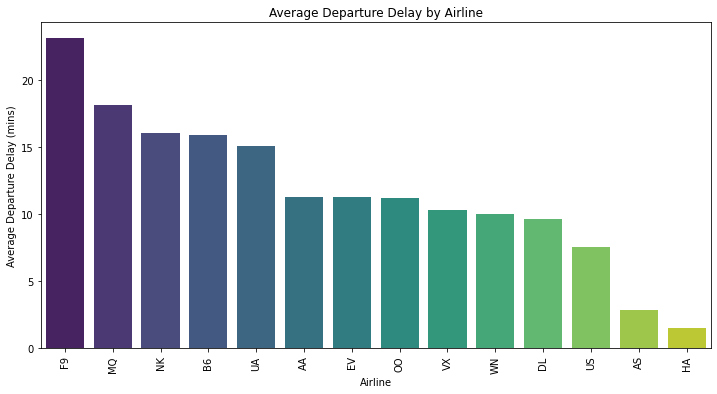

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort values for better visualization
avg_delay_pd = avg_delay_pd.sort_values(by="avg_delay", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="AIRLINE", y="avg_delay", data=avg_delay_pd, palette="viridis")

plt.xticks(rotation=90)
plt.xlabel("Airline")
plt.ylabel("Average Departure Delay (mins)")
plt.title("Average Departure Delay by Airline")
plt.show()
